In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
from scipy.integrate import simps
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties 
from uncertainties import ufloat
import tensorflow as tf

plt.style.use('belle2')
#%jsroot on


%run /afs/desy.de/user/j/jipatel/MT/MC_fit/Files_After_Acceptance/Signal_Background_thesis_final/Function.ipynb

2024-09-03 11:10:07.003145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 11:10:07.054145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 11:10:07.055903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 11:10:08.458188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
file_bkg_ele="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0eepip4Streams.root"
file_signal_ele="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0eepip4Streams.root"


In [3]:
mc_ele_signal,mc_ele_only_signal,mc_ele_scf,mc_ele_bkg, mc_ele_signal_weight,mc_ele_only_signal_weight,mc_ele_scf_weight,mc_ele_bkg_weight = process_MC_data_combined(file_signal_ele, file_bkg_ele, 'ele', '511', 'pip', 'ee', 1, 'rec511','PIDCorrectionAndAcceptanceWeight')


In [4]:
sum(mc_ele_only_signal_weight)

109.37892095609853

In [5]:
fit_and_integrate(mc_ele_signal, param_fl_start=0.5, param_s3_start=0.01, param_p5_start=0.02, floating=True)


/tmp/ipykernel_985710/4262147721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']


name                   value  (rounded)        hesse    at limit
-------------------  ------------------  -----------  ----------
extended_0.63462292             109.379  +/- 9.1e-09       False
param_fl_0.63462292            0.999624  +/- 0.00019       False
param_s3_0.63462292           -0.496084  +/-    0.24       False
param_p5_0.63462292             28.2021  +/-     4.9       False
Fit result valid:
False
Signal Events in MC Data = 109.3789209560985
Integrated PDF with trim: 1.3853066402883287
Integrated PDF without trim: 1.6023470402092486
Proportion of data lost: 0.1355


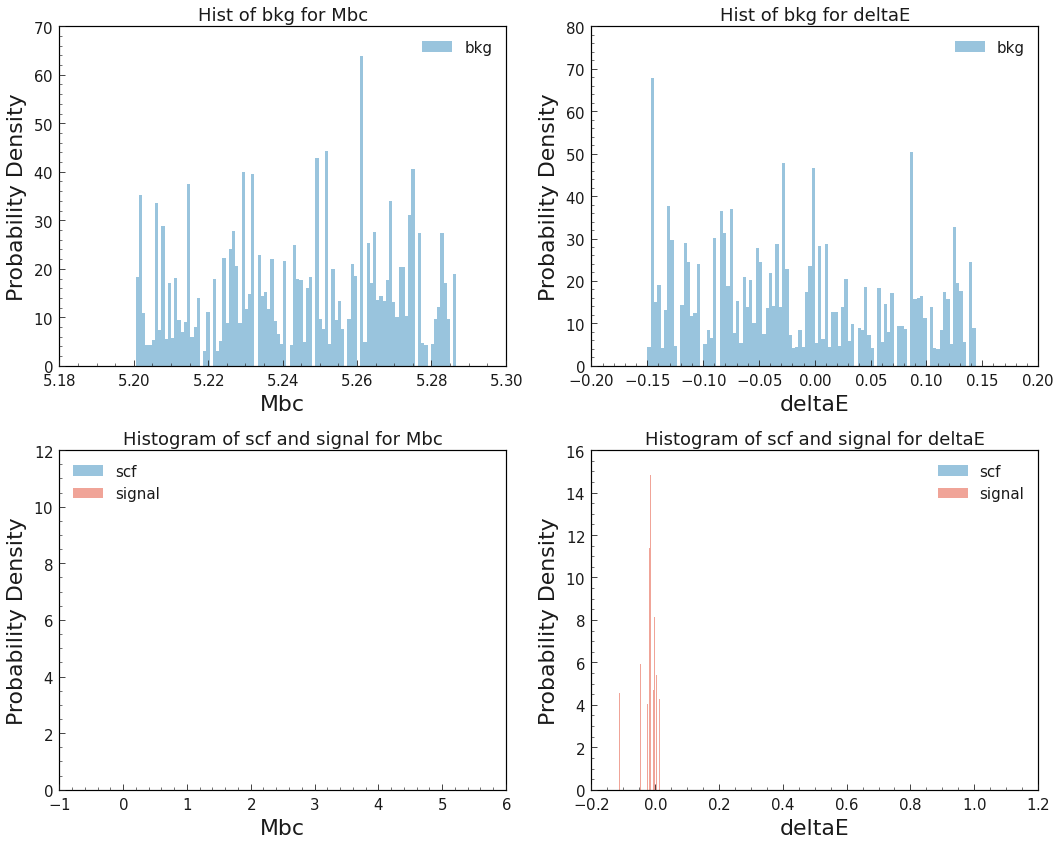

In [6]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Mbc_bkg
plot_histogram(axs[0, 0], {"bkg":  mc_ele_bkg["Mbc"]},
               ["bkg"],
               {"bkg": mc_ele_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of bkg for Mbc')

# deltaE_bkg
plot_histogram(axs[0, 1], {"bkg": mc_ele_bkg["deltaE"]},
               ["bkg"],
               {"bkg": mc_ele_bkg_weight},
               'deltaE', 'Probability Density', 'Hist of bkg for deltaE')

# Mbc_signal 
plot_histogram(axs[1, 0], {"scf": mc_ele_scf["Mbc"], 
                           "signal": mc_ele_only_signal["Mbc"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight}, 
               'Mbc', 'Probability Density', 'Histogram of scf and signal for Mbc')


# deltaE_signal
plot_histogram(axs[1, 1], {"scf": mc_ele_scf["deltaE"], 
                           "signal": mc_ele_only_signal["deltaE"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight},
               'deltaE', 'Probability Density', 'Histogram of scf and signal for deltaE')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Yield

In [7]:
# signal
Mbc_only_signal_cb_fixed = fit_fixed('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',0)


#scf
Mbc_scf_argus_gauss_fixed= fit_fixed('Mbc','ele', 'scf', mc_ele_scf["Mbc"], mc_ele_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss_fixed= fit_fixed('deltaE','ele', 'scf', mc_ele_scf["deltaE"], mc_ele_scf_weight,'poly_gauss',0)


#bkg
Mbc_bkg_argus_gauss_fixed= fit_fixed('Mbc','ele', 'bkg',  mc_ele_bkg["Mbc"], mc_ele_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss_fixed= fit_fixed('deltaE','ele', 'bkg',  mc_ele_bkg["deltaE"], mc_ele_bkg_weight,'poly',0)



In [8]:
Signal_Mbc = mc_ele_only_signal["Mbc"]
Signal_deltaE = mc_ele_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_ele_scf["Mbc"],mc_ele_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_ele_scf["deltaE"],mc_ele_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_ele_only_signal_weight
Background_weight = pd.concat([mc_ele_scf_weight,mc_ele_bkg_weight])

print(sum(Signal_weight))
print(sum(Background_weight))


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model_scf(
    Mbc_only_signal_cb_fixed,Mbc_scf_argus_gauss_fixed,deltaE_only_signal_cb_gauss_fixed,deltaE_scf_poly_gauss_fixed,
    Mbc_bkg_argus_gauss_fixed,deltaE_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight]),0.1,0.1,100,1000
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


109.37892095609853
1497.9379330910333


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                      value  (rounded)               errors    at limit
----------------------  ------------------  -------------------  ----------
signal_yield_0.383                 79.8127  -     13   +     13       False
background_yield_0.383             1527.41  -     40   +     41       False
frac_Mbc_bkg1_0.383              0.0219504  -  0.031   +  0.032       False
frac_deltaE_bkg1_0.383           -0.178653  -   0.13   +   0.13       False
True


/tmp/ipykernel_985710/1109665084.py:57: RuntimeWarning: divide by zero encountered in true_divide
  pulls = (n - y_total_fit_binned) / errors
/tmp/ipykernel_985710/1109665084.py:57: RuntimeWarning: divide by zero encountered in true_divide
  pulls = (n - y_total_fit_binned) / errors


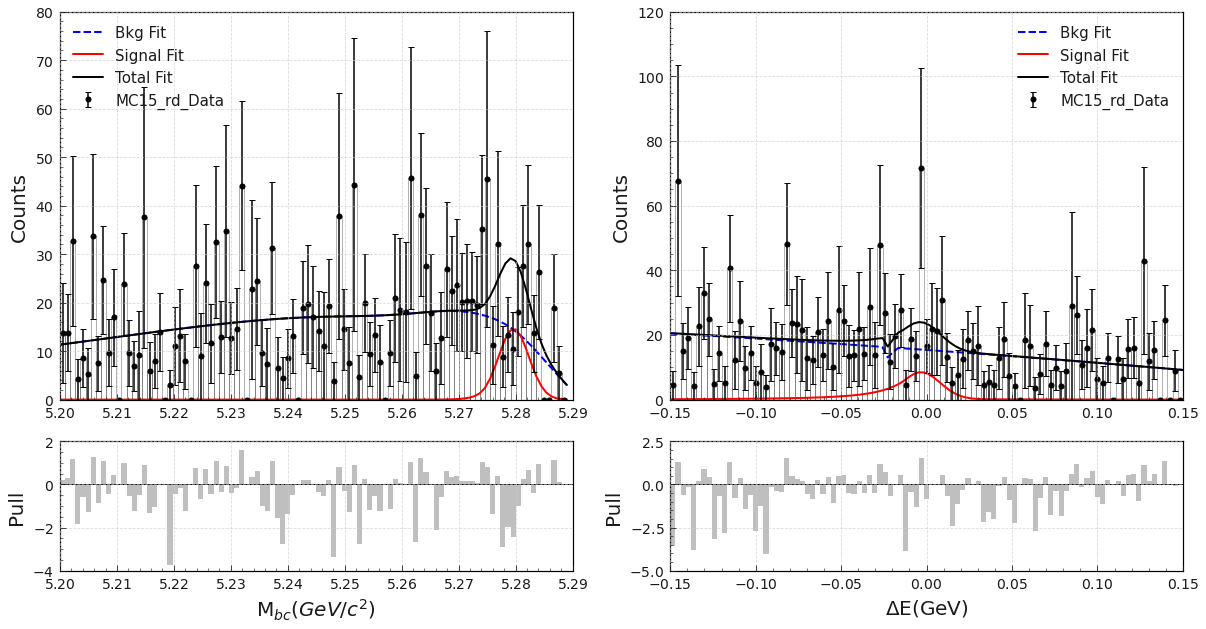

In [9]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit","MC15_rd_Data", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit","MC15_rd_Data","$\\Delta$E(GeV)")


# Adjust layout
plt.tight_layout()

# Show plot
#plt.savefig('B0pip_q2reg1_decay_ee.pdf')
plt.show()
   


In [10]:
# signal
Mbc_only_signal_cb_fixed = fit_fixed('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',0)

#bkg
Mbc_bkg_argus_gauss_fixed = fit_fixed('Mbc','ele', 'bkg',  mc_ele_bkg["Mbc"], mc_ele_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss_fixed = fit_fixed('deltaE','ele', 'bkg',  mc_ele_bkg["deltaE"], mc_ele_bkg_weight,'poly',0)


In [11]:
Signal_Mbc = mc_ele_only_signal["Mbc"]
Signal_deltaE = mc_ele_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_ele_scf["Mbc"],mc_ele_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_ele_scf["deltaE"],mc_ele_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_ele_only_signal_weight
Background_weight = pd.concat([mc_ele_scf_weight,mc_ele_bkg_weight])

print(sum(Signal_weight))
print(sum(Background_weight))


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model(
    Mbc_only_signal_cb_fixed,deltaE_only_signal_cb_gauss_fixed,Mbc_bkg_argus_gauss_fixed,deltaE_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight]),100,1000
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


109.37892095609853
1497.9379330910333


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.2072                 82.2874  -     12   +     12       False
background_yield_0.2072             1524.97  -     39   +     40       False
True


/tmp/ipykernel_985710/1109665084.py:57: RuntimeWarning: divide by zero encountered in true_divide
  pulls = (n - y_total_fit_binned) / errors
/tmp/ipykernel_985710/1109665084.py:57: RuntimeWarning: divide by zero encountered in true_divide
  pulls = (n - y_total_fit_binned) / errors


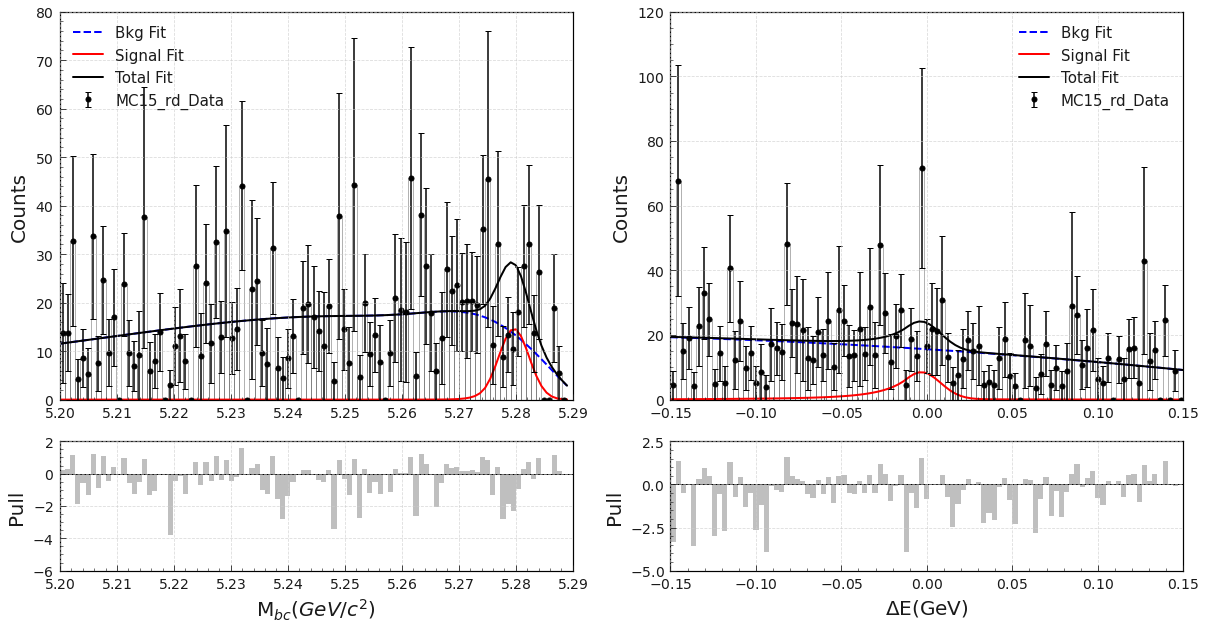

In [12]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit","MC15_rd_Data", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit","MC15_rd_Data","$\\Delta$E(GeV)")


# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('B0pip_q2reg1_decay_ee_rd.pdf')
plt.show()
   


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                      value  (rounded)               errors    at limit
----------------------  ------------------  -------------------  ----------
signal_yield_0.991                 3294.39  -     59   +     60       False
background_yield_0.991              3042.2  -     57   +     58       False
True
name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.9773                 19709.7  -1.4e+02   +1.5e+02       False
background_yield_0.9773             20041.2  -1.5e+02   +1.5e+02       False
True
name                     value  (rounded)               errors    at limit
---------------------  ------------------  -------------------  ----------
signal_yield_0.78                 81379.9  -  3e+02   +  3e+02       False
background_yield_0.78             77969.6  -2.9e+02   +2.9e+02       False
True
name                       value  (rounded)               errors    at li

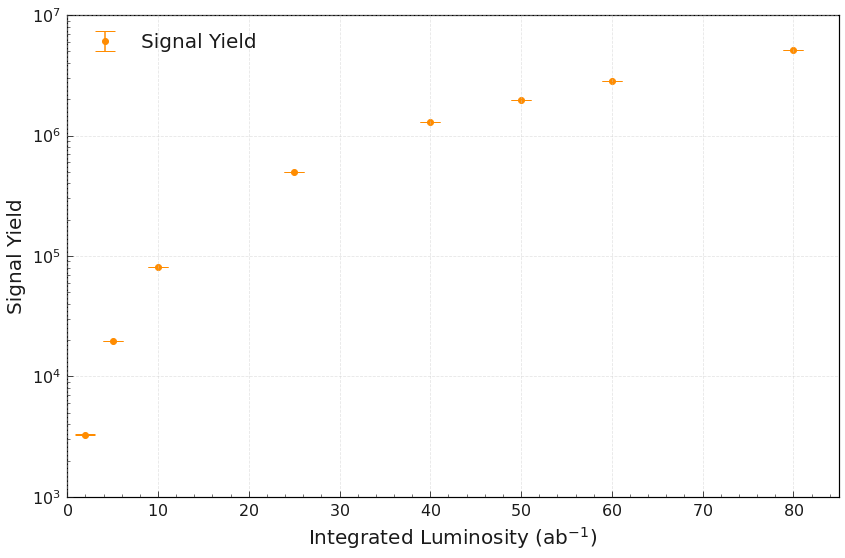

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from uncertainties import ufloat  # Ensure you import this for uncertainty handling

# Assuming result is some fitting result object with parameters
signal_yield_value = result.params[signal_extended.get_yield()]['value']
signal_yield_errors = result.params[signal_extended.get_yield()]['errors']

# Calculate the symmetric uncertainty assuming you have upper and lower errors
signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2
signal_yield_with_uncertainty = ufloat(signal_yield_value, signal_yield_error)

normalization_factor = 0.368 * 4  # Fixed normalization factor

# Define your PDFs using whatever function you have for fitting
Mbc_only_signal_cb_fixed = fit_fixed('Mbc', 'ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight, 'cb', 0)
deltaE_only_signal_cb_gauss_fixed = fit_fixed('deltaE', 'ele', 'signal', mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight, 'cb_gauss', 0)
Mbc_bkg_argus_gauss_fixed = fit_fixed('Mbc', 'ele', 'bkg', mc_ele_bkg["Mbc"], mc_ele_bkg_weight, 'argus_gauss', 0)
deltaE_bkg_poly_fixed = fit_fixed('deltaE', 'ele', 'bkg', mc_ele_bkg["deltaE"], mc_ele_bkg_weight, 'poly', 0)

# Define luminosities to loop over
luminosities = [2, 5, 10, 25,40, 50,60, 80]

# Calculate the number of events per ab^-1
n_events_per_ab1 = signal_yield_value / normalization_factor

# Arrays to store results
signal_yields = []

for lumi in luminosities:
    # Calculate the number of events for this luminosity
    n_events = int(lumi * n_events_per_ab1)  # Convert directly to an integer
    
    # Sample signal events
    Mbc_samples_signal = Mbc_only_signal_cb_fixed.sample(n=n_events).numpy()
    deltaE_samples_signal = deltaE_only_signal_cb_gauss_fixed.sample(n=n_events).numpy()

    # Combine Mbc and deltaE into a single DataFrame for signal
    samples_signal_df = pd.DataFrame({'Mbc': Mbc_samples_signal.flatten(), 'deltaE': deltaE_samples_signal.flatten()})
    
    # Calculate scaled weights for signal
    scaled_signal_weights = pd.Series((Mbc_samples_signal.flatten() + deltaE_samples_signal.flatten()) * (lumi / 0.368))
    
    # Sample background events
    Mbc_samples_bkg = Mbc_bkg_argus_gauss_fixed.sample(n=n_events).numpy()  # Use n_events directly
    deltaE_samples_bkg = deltaE_bkg_poly_fixed.sample(n=n_events).numpy()
    
    # Combine Mbc and deltaE into a single DataFrame for background
    samples_bkg_df = pd.DataFrame({'Mbc': Mbc_samples_bkg.flatten(), 'deltaE': deltaE_samples_bkg.flatten()})
    
    # Calculate scaled weights for background
    scaled_bkg_weights = pd.Series((Mbc_samples_bkg.flatten() + deltaE_samples_bkg.flatten()) * (lumi / 0.368))
    
    # Concatenate signal and background dataframes
    combined_df = pd.concat([samples_signal_df, samples_bkg_df], axis=0)
    
    # Concatenate weights for signal and background
    combined_weights = pd.concat([scaled_signal_weights, scaled_bkg_weights], axis=0)
    
    # Perform the fit with the combined data and weights
    Mbc_signal_pdf, deltaE_signal_pdf, Mbc_background_pdf, deltaE_background_pdf, signal_extended, background_extended, total_model, result = fit_extended_model(
        Mbc_only_signal_cb_fixed, deltaE_only_signal_cb_gauss_fixed, Mbc_bkg_argus_gauss_fixed, deltaE_bkg_poly_fixed,
        combined_df, combined_weights, 100, 100
    )

    # Optionally calculate errors or perform other fitting operations
    result.errors(name='errors')
    print(result.params)
    print(result.valid)

    # Retrieve and store the signal yield and its error
    signal_yield = result.params[signal_extended.get_yield()]['value']
    signal_yield_errors = result.params[signal_extended.get_yield()]['errors']
    signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2

    # Store the signal yield and error as a tuple in the list
    signal_yields.append((lumi, signal_yield, signal_yield_error))

# Convert the list to a DataFrame with columns for luminosity, signal yield, and its error
events_per_luminosity = pd.DataFrame(signal_yields, columns=['luminosity', 'signal_yield', 'signal_yield_error'])

# Extract data for plotting
luminosities = events_per_luminosity['luminosity']
signal_yields = events_per_luminosity['signal_yield']
signal_yield_errors = events_per_luminosity['signal_yield_error']

print(luminosities)
print(signal_yields)
print(signal_yield_errors)

# Plot the Signal Yield vs. Luminosity
plt.figure(figsize=(12, 8))
plt.errorbar(luminosities, signal_yields, yerr=signal_yield_errors, fmt='o', capsize=10, label='Signal Yield', color='darkorange')

#plt.title('Signal Yield vs. Integrated Luminosity', fontsize=20, fontweight='bold')
plt.xlabel('Integrated Luminosity (ab$^{-1}$)', fontsize=20)
plt.yscale("log")
plt.ylabel('Signal Yield', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=20)

plt.xlim(0, 85)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig("B0pip_q2reg1_decay_ee_Signal_Yield_Integrated_Luminosity.pdf", format='pdf')  # Corrected this line
plt.show()


